# Customizing OpenAI Gym Environments and Implementing Reinforcement Learning Agents with Stable Baselines

### Theme: Car Racing

- Constança Fernandes, 202205398
- Daniela Osório, 202208679
- Inês Amorim, 202108108

---

## Imports

In [ ]:
%pip install -r requirements.txt

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install jupyter_http_over_ws

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.2 MB/s eta 0:00:00


In [ ]:
!pip install swig
!pip install gymnasium[box2d]
!pip install stable-baselines3 gym[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 49.2 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.1.0
    Uninstalling pygame-2.1.0:
      Successfully uninstalled pygame-2.1.0
  Using cached pygame-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.5 kB)
Using cached pygame-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6.1
    Uninstalling pygame-2.6.1:
      Successfully uninstalled pygame-2.6.1


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/reinforcement-learning-with-gymnasium-main')

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import GrayscaleObservation, ResizeObservation, RecordEpisodeStatistics, RecordVideo, TimeLimit
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.atari_wrappers import WarpFrame
from stable_baselines3.common.vec_env import VecFrameStack, VecVideoRecorder
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CheckpointCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecTransposeImage
from stable_baselines3.common.vec_env import VecNormalize
import os
import gc
from eval import *
from custom_cr import EnhancedCarRacing

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute


---

## 1. Introduction

The CarRacing-v3 environment from Gymnasium (previously Gym) is part of the Box2D environments, and it offers an interesting challenge for training reinforcement learning agents. It's a top-down racing simulation where the track is randomly generated at the start of each episode. The environment offers both continuous and discrete action spaces, making it adaptable to different types of reinforcement learning algorithms.

In [ ]:
env = gym.make("CarRacing-v3", continuous=False, render_mode='rgb_array')
obs, info = env.reset()
#continuous = False to use Discrete space

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:27: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

- **Action Space:**

   - **Continuous:** Three actions: steering, gas, and braking. Steering ranges from -1 (full left) to +1 (full right).
   -  **Discrete:** Five possible actions: do nothing, steer left, steer right, gas, and brake.

- **Observation Space:**

    - The environment provides a 96x96 RGB image of the car and the track, which serves as the state input for the agent.

- **Rewards:**

    - The agent receives a -0.1 penalty for every frame, encouraging efficiency.
    - It earns a positive reward for visiting track tiles: the formula is Reward=1000−0.1×framesReward=1000−0.1×frames, where "frames" is the number of frames taken to complete the lap. The reward for completing a lap depends on how many track tiles are visited.

- **Episode Termination:**

    - The episode ends either when all track tiles are visited or if the car goes off the track, which incurs a significant penalty (-100 reward).

In [ ]:
#check render modes
print(env.metadata["render_modes"])

['human', 'rgb_array', 'state_pixels']


- Checking if everything is okay and working

In [ ]:
# Reset the environment and render the first frame
obs, info = env.reset()

# Close the environment
env.close()

print("Environment initialized successfully!")

Environment initialized successfully!


In [ ]:
print("Action space:", env.action_space)

Action space: Discrete(5)


In [ ]:
print("Action Space:", env.action_space)
print("Observation Space:", env.observation_space)
print("Environment Metadata:", env.metadata)

Action Space: Discrete(5)
Observation Space: Box(0, 255, (96, 96, 3), uint8)
Environment Metadata: {'render_modes': ['human', 'rgb_array', 'state_pixels'], 'render_fps': 50}


In [ ]:
obs = env.reset()
for _ in range(10):
    """action = env.action_space.sample()  # Random action
    print(f"Action before step: {action}, Type: {type(action)}")
    obs, reward, done, info = env.step(action)"""
    env.step(env.action_space.sample())

env.close()

---
## 2. Training

Deep Q-Learning (DQN) is a reinforcement learning algorithm that extends the traditional Q-Learning method using neural networks to approximate the Q-values for state-action pairs.
DQN is inherently designed for discrete action spaces, as the neural network outputs a separate Q-value for each action. For each state, the algorithm selects actions based on the highest Q-value, making it ideal for problems where actions are discrete and finite. This is a key advantage compared to other reinforcement learning methods, which may require modifications or different approaches for discrete action selection.

In [ ]:
MODELS_DIR = '../2.2.1/models'

### 2.1. Baseline

#### 2.1.1. DQN

In [ ]:
env = gym.make("CarRacing-v3", continuous=False)
print(env.spec)

EnvSpec(id='CarRacing-v3', entry_point='gymnasium.envs.box2d.car_racing:CarRacing', reward_threshold=900, nondeterministic=False, max_episode_steps=1000, order_enforce=True, disable_env_checker=False, kwargs={'continuous': False}, namespace=None, name='CarRacing', version=3, additional_wrappers=(), vector_entry_point=None)


In [ ]:
obs = env.reset()
print(obs[0].shape)

(96, 96, 3)


In [ ]:
#create directories
logs_dir = 'DQN_baseline_logs'
logs_path = os.path.join(MODELS_DIR, logs_dir)
os.makedirs(logs_path, exist_ok=True)

video_dir = os.path.join(logs_path, "videos")
tensorboard_dir = os.path.join(logs_path, "tensorboard")
model_dir = os.path.join(logs_path, "models")
os.makedirs(video_dir, exist_ok=True)
os.makedirs(tensorboard_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [ ]:
# Simple DQN architecture
policy_kwargs = dict(net_arch=[64, 64])  # Simpler architecture with 2 layers of 64 units

# Set up the model with simpler hyperparameters
model = DQN('CnnPolicy', env, policy_kwargs=policy_kwargs,
            verbose=1, buffer_size=50000, learning_starts=1000,
            learning_rate=0.0005, batch_size=32, exploration_fraction=0.1,
            exploration_final_eps=0.05)

# Setup evaluation and checkpoint callbacks
eval_callback = EvalCallback(env, best_model_save_path=model_dir,
                             log_path=model_dir, eval_freq=5000, n_eval_episodes=5,
                             deterministic=True, render=False)

checkpoint_callback = CheckpointCallback(save_freq=10000, save_path=model_dir,
                                         name_prefix='dqn_model_checkpoint')



# Start training the model with callbacks for evaluation and checkpoints
model.learn(total_timesteps=1_000_000, callback=[eval_callback, checkpoint_callback])

# Save the final model after training
model.save("dqn_car_racing_model")
env.close()

In [ ]:
env.close()
del env
foo = gc.collect()

#### 2.1.2. PPO

In [ ]:
MODELS_DIR = '/content/drive/MyDrive/reinforcement-learning-with-gymnasium-main/ppo_car_racing_model'

In [ ]:
env = gym.make("CarRacing-v3", continuous=False)
print("Observation Space Size: ", env.observation_space.shape)
print("Action Space Size: ", env.action_space.shape)
obs = env.reset()

Observation Space Size:  (96, 96, 3)
Action Space Size:  ()


In [ ]:
env_str = "CarRacing-v3"
log_dir = "./logs/{}".format(env_str)
gray_scale = True

# If gray_scale True, convert obs to gray scale 84 x 84 image
wrapper_class = WarpFrame if gray_scale else None

In [ ]:
#create directories
logs_dir = 'PPO_baseline_logs'
logs_path = os.path.join(MODELS_DIR, logs_dir)
os.makedirs(logs_path, exist_ok=True)

video_dir = os.path.join(logs_path, "videos")
tensorboard_dir = os.path.join(logs_path, "tensorboard")
model_dir = os.path.join(logs_path, "models")
os.makedirs(video_dir, exist_ok=True)
os.makedirs(tensorboard_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [ ]:
# Simple PPO architecture
policy_kwargs = dict(net_arch=[64, 64])  # Simpler architecture with 2 layers of 64 units

# Create Training CarRacing environment
env = make_vec_env(env_str, n_envs=1, wrapper_class=wrapper_class)
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)
#env = VecNormalize(env, norm_reward=True)

# Create Evaluation CarRacing environment
env_val = make_vec_env(env_str, n_envs=1, wrapper_class=wrapper_class)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

# Evaluation Callback
eval_callback = EvalCallback(env, best_model_save_path=model_dir,
                             log_path=model_dir, eval_freq=10_000, n_eval_episodes=5,
                             deterministic=True, render=False)

#PPO
model = PPO('CnnPolicy', env, policy_kwargs=policy_kwargs,
            n_steps=10_000, verbose=1, ent_coef=0.005,
            learning_rate=0.0005, batch_size=32)


checkpoint_callback = CheckpointCallback(save_freq=10_000, save_path=model_dir,
                                         name_prefix='ppo_model_checkpoint')


# Start training the model with callbacks for evaluation and checkpoints
model.learn(total_timesteps=100_000, progress_bar=True, callback=[eval_callback, checkpoint_callback])

model.save("ppo_env_model")
#model.save(os.path.join(log_dir, "ppo_car_racing"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Using cpu device


/usr/local/lib/python3.10/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 32, but because the `RolloutBuffer` is of size `n_steps * n_envs = 10000`, after every 312 untruncated mini-batches, there will be a truncated mini-batch of size 16
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=10000 and n_envs=1)
  warnings.warn(


Output()

Eval num_timesteps=10000, episode_reward=-93.11 +/- 0.57

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -93.1    |
| time/              |          |
|    total_timesteps | 10000    |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    fps             | 23       |
|    iterations      | 1        |
|    time_elapsed    | 420      |
|    total_timesteps | 10000    |
---------------------------------


Eval num_timesteps=20000, episode_reward=-93.52 +/- 0.54

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -93.5       |
| time/                   |             |
|    total_timesteps      | 20000       |
| train/                  |             |
|    approx_kl            | 0.006064357 |
|    clip_fraction        | 0.0665      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.2        |
|    explained_variance   | -0.0115     |
|    learning_rate        | 0.0005      |
|    loss                 | 0.351       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00273    |
|    std                  | 0.976       |
|    value_loss           | 0.678       |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -57.3    |
| time/              |          |
|    fps             | 16       

Eval num_timesteps=30000, episode_reward=-93.28 +/- 0.59

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | -93.3        |
| time/                   |              |
|    total_timesteps      | 30000        |
| train/                  |              |
|    approx_kl            | 0.0074582486 |
|    clip_fraction        | 0.0739       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.14        |
|    explained_variance   | 0.0508       |
|    learning_rate        | 0.0005       |
|    loss                 | 0.566        |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.00429     |
|    std                  | 0.96         |
|    value_loss           | 0.779        |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -51.1    |
| time/              |          |
|    fps     

Eval num_timesteps=40000, episode_reward=-93.15 +/- 0.46

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -93.2       |
| time/                   |             |
|    total_timesteps      | 40000       |
| train/                  |             |
|    approx_kl            | 0.006437389 |
|    clip_fraction        | 0.0589      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.11       |
|    explained_variance   | 0.0406      |
|    learning_rate        | 0.0005      |
|    loss                 | 0.168       |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00356    |
|    std                  | 0.956       |
|    value_loss           | 0.993       |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -45.7    |
| time/              |          |
|    fps             | 13       

Eval num_timesteps=50000, episode_reward=-93.27 +/- 0.60

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | -93.3        |
| time/                   |              |
|    total_timesteps      | 50000        |
| train/                  |              |
|    approx_kl            | 0.0070858696 |
|    clip_fraction        | 0.0705       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.08        |
|    explained_variance   | 0.0362       |
|    learning_rate        | 0.0005       |
|    loss                 | 0.697        |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.0054      |
|    std                  | 0.944        |
|    value_loss           | 1.11         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -41.5    |
| time/              |          |
|    fps     

Eval num_timesteps=60000, episode_reward=-93.04 +/- 0.37

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | -93          |
| time/                   |              |
|    total_timesteps      | 60000        |
| train/                  |              |
|    approx_kl            | 0.0064649154 |
|    clip_fraction        | 0.0607       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.03        |
|    explained_variance   | 0.031        |
|    learning_rate        | 0.0005       |
|    loss                 | 0.461        |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.0037      |
|    std                  | 0.927        |
|    value_loss           | 1.25         |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -39.2    |
| time/              |          |
|    fps             | 12       |
|    iterations      | 6        |
|    time_elapsed    | 4669     |
|    total_timesteps | 60000    |
---------------------------------


Eval num_timesteps=70000, episode_reward=-93.33 +/- 0.33

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -93.3       |
| time/                   |             |
|    total_timesteps      | 70000       |
| train/                  |             |
|    approx_kl            | 0.006622155 |
|    clip_fraction        | 0.0651      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.96       |
|    explained_variance   | 0.0309      |
|    learning_rate        | 0.0005      |
|    loss                 | 0.392       |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00455    |
|    std                  | 0.911       |
|    value_loss           | 1.19        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -35.7    |
| time/              |          |
|    fps             | 12       

Eval num_timesteps=80000, episode_reward=-93.02 +/- 0.14

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | -93          |
| time/                   |              |
|    total_timesteps      | 80000        |
| train/                  |              |
|    approx_kl            | 0.0051716054 |
|    clip_fraction        | 0.051        |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.94        |
|    explained_variance   | 0.0219       |
|    learning_rate        | 0.0005       |
|    loss                 | 0.643        |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.00247     |
|    std                  | 0.904        |
|    value_loss           | 2.01         |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -33.4    |
| time/              |          |
|    fps             | 12       |
|    iterations      | 8        |
|    time_elapsed    | 6399     |
|    total_timesteps | 80000    |
---------------------------------


Eval num_timesteps=90000, episode_reward=-93.00 +/- 0.78

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -32.3    |
| time/              |          |
|    fps             | 12       |
|    iterations      | 9        |
|    time_elapsed    | 7235     |
|    total_timesteps | 90000    |
---------------------------------


Eval num_timesteps=100000, episode_reward=-93.16 +/- 0.14

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -93.2       |
| time/                   |             |
|    total_timesteps      | 100000      |
| train/                  |             |
|    approx_kl            | 0.004595625 |
|    clip_fraction        | 0.0358      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.84       |
|    explained_variance   | 0.019       |
|    learning_rate        | 0.0005      |
|    loss                 | 1.45        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00132    |
|    std                  | 0.873       |
|    value_loss           | 2.53        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -31.7    |
| time/              |          |
|    fps             | 12       

Mean reward: -93.10 +/- 0.49


In [ ]:
# Path to the saved model
model_path = '/content/drive/MyDrive/reinforcement-learning-with-gymnasium-main/ppo_car_racing_model/PPO_baseline_logs/models/ppo_model_checkpoint_20000_steps.zip'

# Load the model
model = PPO.load(model_path)

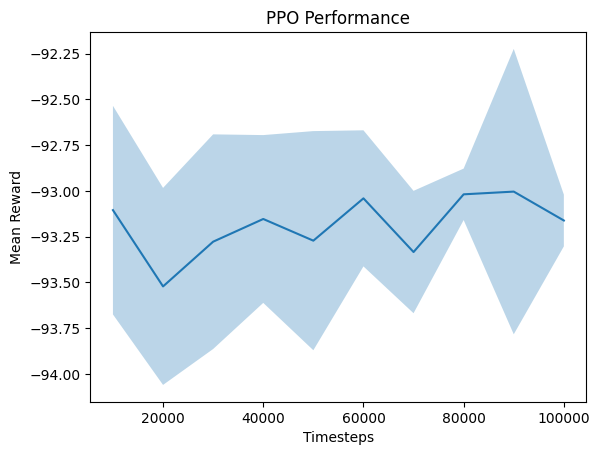

In [ ]:
import numpy
import matplotlib

# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "/content/drive/MyDrive/reinforcement-learning-with-gymnasium-main/ppo_car_racing_model/PPO_baseline_logs/models/evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title('PPO Performance')
matplotlib.pyplot.show()

In [ ]:
env.close()
del env
foo = gc.collect()

### 2.2. Environment and Reward Modifications

| **Modification**            | **Description**                                                                                      | **Effect**                                     |
|-----------------------------|------------------------------------------------------------------------------------------------------|-----------------------------------------------|
| **Obstacles**               | Randomly placed obstacles on the track.                                                             | Requires avoidance and navigation skills.     |
| **Track Width Variability** | Random track width adjustments between `[0.8, 1.2]`.                                                | Simulates narrow/wide tracks dynamically.     |
| **Weather Conditions**      | Introduces "rain" and "snow," which alter action effectiveness.                                     | Adds randomness and realism to driving.       |
| **Off-Track Penalty**       | Reward reduced by `-10` if the car leaves the track.                                                | Encourages the agent to stay on track.        |
| **Distance Reward**         | Positive reward based on the distance traveled per step.                                            | Incentivizes efficient driving.               |
| **Obstacle Proximity Penalty** | Penalty inversely proportional to the distance to nearby obstacles (`1 / (d + 1e-6)`).             | Encourages the car to avoid obstacles safely. |


#### 2.2.1 DQN

In [ ]:
custom_env = EnhancedCarRacing(render_mode="rgb_array")
obs, info = custom_env.reset()

print("Initial observation shape:", obs.shape)
print("Initial info:", info)

for i in range(10):
    action = custom_env.action_space.sample()  # Your agent would make a decision here
    observation, reward, terminated, truncated, info = custom_env.step(action)
    print(f"\nStep {i+1}:")
    print("Action taken:", action)
    print("Reward:", reward)
    print("Terminated:", terminated)
    print("Truncated:", truncated)
    print("Info:", info)

    if hasattr(custom_env, 'weather_condition'):
        print("Current weather:", custom_env.weather_condition)

    if terminated or truncated:
        print("Episode ended")
        break

custom_env.close()

Initial observation shape: (96, 96, 3)
Initial info: {}

Step 1:
Action taken: 2
Reward: 5.804336925215569
Terminated: False
Truncated: False
Info: {}
Current weather: rain

Step 2:
Action taken: 3
Reward: -0.37469043040753186
Terminated: False
Truncated: False
Info: {}
Current weather: rain

Step 3:
Action taken: 0
Reward: -0.4746904304075319
Terminated: False
Truncated: False
Info: {}
Current weather: rain

Step 4:
Action taken: 0
Reward: -0.5746904304075319
Terminated: False
Truncated: False
Info: {}
Current weather: rain

Step 5:
Action taken: 1
Reward: -0.6746904304075318
Terminated: False
Truncated: False
Info: {}
Current weather: rain

Step 6:
Action taken: 3
Reward: -0.7746904304075318
Terminated: False
Truncated: False
Info: {}
Current weather: rain

Step 7:
Action taken: 1
Reward: -0.8746904304075318
Terminated: False
Truncated: False
Info: {}
Current weather: rain

Step 8:
Action taken: 0
Reward: -0.9746904304075318
Terminated: False
Truncated: False
Info: {}
Current weather

In [ ]:
custom_env = GrayscaleObservation(custom_env, keep_dim=True)
custom_env = TimeLimit(custom_env, max_episode_steps=1000)

In [ ]:
print(custom_env)

<TimeLimit<GrayscaleObservation<EnhancedCarRacing instance>>>


In [ ]:
print("Action space:", custom_env.action_space)

Action space: Discrete(5)


In [ ]:
#create directories
logs_dir = 'DQN_env_mod_logs'
logs_path = os.path.join(MODELS_DIR, logs_dir)
os.makedirs(logs_path, exist_ok=True)

tensorboard_dir = os.path.join(logs_path, "tensorboard")
model_dir = os.path.join(logs_path, "models")
os.makedirs(tensorboard_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [ ]:
# Simple DQN architecture
policy_kwargs = dict(net_arch=[64, 64])  # Simpler architecture with 2 layers of 64 units

# Set up the model with simpler hyperparameters
model = DQN('CnnPolicy', custom_env, policy_kwargs=policy_kwargs,
            verbose=1, buffer_size=50000, learning_starts=1000,
            learning_rate=0.0005, batch_size=32, exploration_fraction=0.1,
            exploration_final_eps=0.05)

# Setup evaluation and checkpoint callbacks
eval_callback = EvalCallback(custom_env, best_model_save_path=model_dir,
                             log_path=model_dir, eval_freq=5000, n_eval_episodes=5,
                             deterministic=True, render=False)

checkpoint_callback = CheckpointCallback(save_freq=10000, save_path=model_dir,
                                         name_prefix='dqn_model_checkpoint')



# Start training the model with callbacks for evaluation and checkpoints
model.learn(total_timesteps=1_000_000, callback=[eval_callback, checkpoint_callback])

# Save the final model after training
model.save("dqn_custom_env_model")
custom_env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[W1218 10:05:02.050906178 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.
/home/derpy/Documents/Fac/ano3/semestre1/ISIA/reinforcement-learning-with-gymnasium/.venv/lib/python3.12/site-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x7eaf196b5eb0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7eaf159685c0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 1e+03     |
|    ep_rew_mean      | -5.02e+04 |
|    exploration_rate | 0.962     |
| time/               |           |
|    episodes         | 4         |
|    fps              | 28        |
|    time_elapsed     | 141       |
|    total_timesteps  | 4000      |
| train/              |           |
|    learning_rate    | 0.0005    |
|    loss             | 5.12      |
|    n_updates        | 749       |
-----------------------------------


/home/inesamorim46/3ano1sem/isia/reinforcement-learning-with-gymnasium/.venv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=-50215.65 +/- 9.31
Episode length: 1000.00 +/- 0.00
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 1e+03     |
|    mean_reward      | -5.02e+04 |
| rollout/            |           |
|    exploration_rate | 0.953     |
| time/               |           |
|    total_timesteps  | 5000      |
| train/              |           |
|    learning_rate    | 0.0005    |
|    loss             | 3.93      |
|    n_updates        | 999       |
-----------------------------------
New best mean reward!
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 1e+03     |
|    ep_rew_mean      | -5.02e+04 |
|    exploration_rate | 0.924     |
| time/               |           |
|    episodes         | 8         |
|    fps              | 17        |
|    time_elapsed     | 463       |
|    total_timesteps  | 8000      |
| train/              |           |
|    learning_rate    

In [ ]:
custom_env.close()
del custom_env
foo = gc.collect()

#### 2.2.2 PPO

In [ ]:
custom_env = EnhancedCarRacing(render_mode="rgb_array")
obs, info = custom_env.reset()
custom_env = GrayscaleObservation(custom_env, keep_dim=True)
custom_env = TimeLimit(custom_env, max_episode_steps=1000)

In [ ]:
#create directories
logs_dir = 'PPO_env_mod_logs'
logs_path = os.path.join(MODELS_DIR, logs_dir)
os.makedirs(logs_path, exist_ok=True)

tensorboard_dir = os.path.join(logs_path, "tensorboard")
model_dir = os.path.join(logs_path, "models")
os.makedirs(tensorboard_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [ ]:
# Simple DQN architecture
policy_kwargs = dict(net_arch=[64, 64])  # Simpler architecture with 2 layers of 64 units

# Set up the model with simpler hyperparameters
model = PPO('CnnPolicy', custom_env, policy_kwargs=policy_kwargs,
            verbose=1, learning_rate=0.0005, batch_size=32)

# Setup evaluation and checkpoint callbacks
eval_callback = EvalCallback(custom_env, best_model_save_path=model_dir,
                             log_path=model_dir, eval_freq=5000, n_eval_episodes=5,
                             deterministic=True, render=False)

checkpoint_callback = CheckpointCallback(save_freq=10000, save_path=model_dir,
                                         name_prefix='ppo_model_checkpoint')



# Start training the model with callbacks for evaluation and checkpoints
model.learn(total_timesteps=1_000_000, callback=[eval_callback, checkpoint_callback])

# Save the final model after training
model.save("ppo_custom_env_model")
custom_env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[W1217 21:07:15.281412367 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.
/home/derpy/Documents/Fac/ano3/semestre1/ISIA/reinforcement-learning-with-gymnasium/.venv/lib/python3.12/site-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x76bd92db0620> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x76bd92db1970>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+03     |
|    ep_rew_mean     | -5.02e+04 |
| time/              |           |
|    fps             | 77        |
|    iterations      | 1         |
|    time_elapsed    | 26        |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -5.02e+04    |
| time/                   |              |
|    fps                  | 55           |
|    iterations           | 2            |
|    time_elapsed         | 73           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0035775134 |
|    clip_fraction        | 0.0174       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.22        |
|    explained_variance   | 4.82e-05     |
|    

/home/derpy/Documents/Fac/ano3/semestre1/ISIA/reinforcement-learning-with-gymnasium/.venv/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=-50217.84 +/- 10.32
Episode length: 1000.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | -5.02e+04    |
| time/                   |              |
|    total_timesteps      | 5000         |
| train/                  |              |
|    approx_kl            | 0.0011489361 |
|    clip_fraction        | 0.0149       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.18        |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0005       |
|    loss                 | 3.68e+05     |
|    n_updates            | 20           |
|    policy_gradient_loss | 0.000451     |
|    std                  | 0.975        |
|    value_loss           | 8.78e+05     |
------------------------------------------
New best mean reward!
----------------------------------
| rollout/           |           

In [ ]:
env.close()
del env
foo = gc.collect()

---

# 3. Evaluation

In [ ]:
# Adjust number of episodes based on the environment's characteristics
if hasattr(env, "max_episode_steps"):
    # If the environment has predefined max steps, use a higher number for evaluation
    num_episodes = 50
else:
    # For simpler environments, use fewer episodes
    num_episodes = 20

In [ ]:
model = foo #load best model

In [ ]:
obs = env.reset()
episode_rewards = []
for episode in range(num_episodes):
    total_reward = 0
    while True:
        action = model.predict(obs)  # Use trained policy
        obs, reward, done, info = env.step(action)
        total_reward += reward
        record_agent_dynamics(env)  # Record smoothness metrics
        if done:
            break
    episode_rewards.append(total_reward)
    obs = env.reset()

print(f"Average Reward: {np.mean(episode_rewards)}")


---

# Gravar os video

In [ ]:
# DQN original

# Define a Environment
env = gym.make("CarRacing-v3", continuous=False, render_mode='rgb_array')

# Video recorder wrapper
trigger = lambda t: t == 0
env = RecordVideo(
    env,
    video_folder=f"./recordings/original/DQN",
    episode_trigger=trigger,
    video_length=0,
    disable_logger=True,
)

model = DQN.load(path="best_model/best_model_2.1.1.zip", env=env)


# Perform N Episodes
for ep in range(1):
    print("Running episode", ep)
    obs, info = env.reset()
    trunc = False
    while not trunc:
        # pass observation to model to get predicted action
        action, _states = model.predict(obs, deterministic=True)

        # pass action to env and get info back
        obs, rewards, trunc, done, info = env.step(action)

        # show the environment on the screen
        env.render()
        # print(ep, rewards, trunc)
        # print("---------------")

    # Close the Environment
    env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/home/psuper/Documents/Escola/Universidade/3º Ano/1_sem/isia/trab2/Gym-RL-Project-ISIA/.venv/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.77GB > 0.74GB
  warnings.warn(


Running episode 0


In [ ]:
# PPO custom

# Define a Environment
env = EnhancedCarRacing(render_mode="rgb_array")
env = GrayscaleObservation(env, keep_dim=True)
# env = TimeLimit(env, max_episode_steps=1000)

# Video recorder wrapper
trigger = lambda t: t == 0
env = RecordVideo(
    env,
    video_folder=f"./recordings/custom/PPO",
    episode_trigger=trigger,
    video_length=0,
    disable_logger=True,
)

model = PPO.load(path="best_model/best_model_2.2.2.zip", env=env)


# Perform N Episodes
for ep in range(1):
    print("Running episode", ep)
    obs, info = env.reset()
    trunc = False
    while not trunc:
        # pass observation to model to get predicted action
        action, _states = model.predict(obs, deterministic=True)

        # pass action to env and get info back
        obs, rewards, trunc, done, info = env.step(action)

        # show the environment on the screen
        env.render()
        # print(ep, rewards, trunc)
        # print("---------------")

    # Close the Environment
    env.close()

/home/psuper/Documents/Escola/Universidade/3º Ano/1_sem/isia/trab2/Gym-RL-Project-ISIA/.venv/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/psuper/Documents/Escola/Universidade/3º Ano/1_sem/isia/trab2/Gym-RL-Project-ISIA/reinforcement-learning-with-gymnasium/recordings/PPO folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/home/psuper/Documents/Escola/Universidade/3º Ano/1_sem/isia/trab2/Gym-RL-Project-ISIA/.venv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(
/home/psuper/Documents/Escola/Universidade/3º Ano/1_sem/isia/trab2/Gym-RL-Project-ISIA/.venv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:167: UserWarning:

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


ValueError: Action spaces do not match: Box([-1.  0.  0.], 1.0, (3,), float32) != Discrete(5)